In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# source the nxcals python libs
from nxcals.api.extraction.data.builders import *
from datetime import datetime
from datetime import timedelta
import pickle
from matplotlib import gridspec
import seaborn as sns

def my_mpl_style():
    '''Sets my preferred style options for matplotlib.'''
    import matplotlib as mpl
    # Font sizes
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['legend.fontsize'] = 18
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = (-2, 3)
my_mpl_style()

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Time in UTC
start = "2022-11-23 17:40:00"
stop = "2022-11-23 22:00:00"
selector = 'CPS.USER.MD5'

spills = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(stop).entity().parameter("T08.XSEC070-I/IntensityMeasurement").build()
df_spills = spills.filter(spills.selector==selector).toPandas()

23/06/12 11:27:23 WARN URLConfigurationSource: No URLs will be polled as dynamic configuration sources.
23/06/12 11:27:31 WARN CheckAllocator: More than one DefaultAllocationManager on classpath. Choosing first found


In [3]:
# Convert the 'acqStamp' column to datetime and create a new column
df_spills['timestamp'] = pd.to_datetime(df_spills['acqStamp'], unit='ns')
df_spills_sorted = df_spills.sort_values(by='timestamp')

Text(0.5, 0, 'Time UTC')

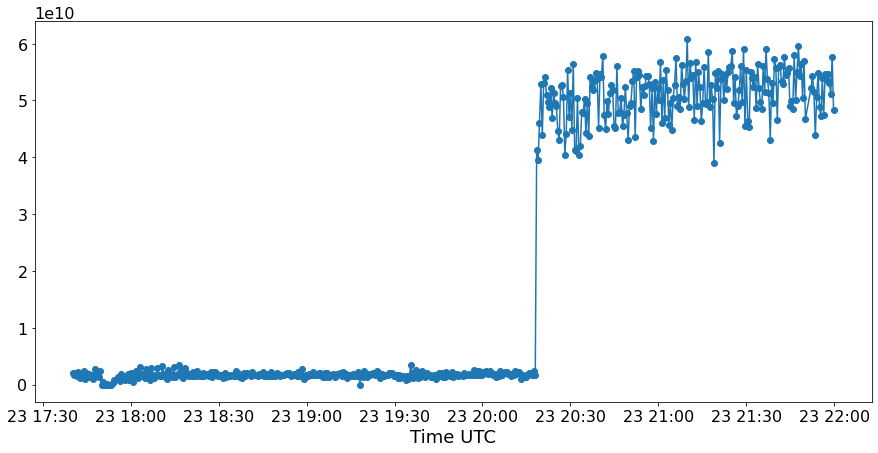

In [4]:
fig, ax = plt.subplots(figsize=(15,7))

ax.plot(df_spills_sorted.timestamp, df_spills_sorted.intensity, marker="o")
ax.set_xlabel("Time UTC")

# Open the gain dataframe

In [5]:
with open('../quad-scan-east/rfko_gain_dataframe.pickle', 'rb') as f:
    gain_df = pickle.load(f)
gain_df['timestamp'] -= timedelta(hours=1)

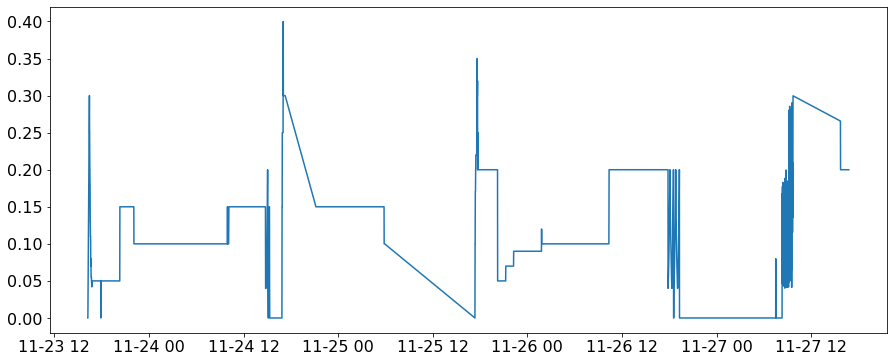

In [6]:
# Subset the DataFrame where energy is equal to 650
gain_df = gain_df[gain_df['energy'] == 650]


# Create a figure and axis objects
fig, ax = plt.subplots(figsize=(15,6))

# Plot the timestamp and gain from the subset DataFrame
ax.plot(gain_df['timestamp'], gain_df['gain'])

# Show the plot
plt.show()

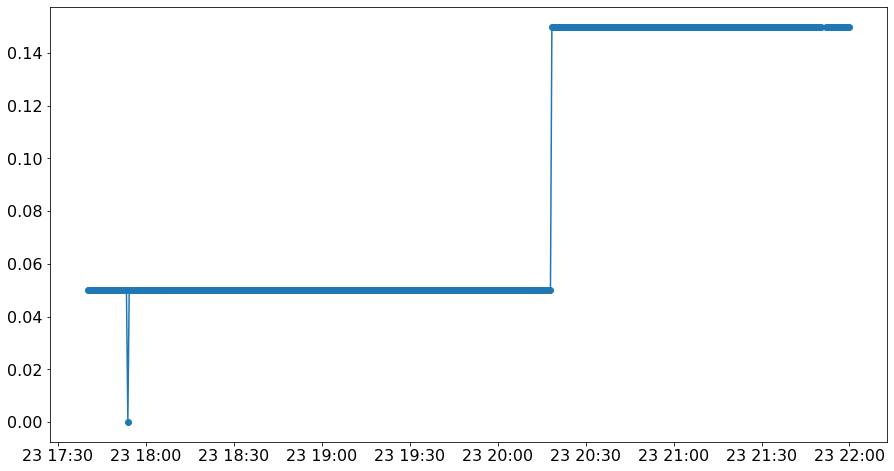

In [7]:
# Convert 'timestamp' column to pandas datetime if it's not already
gain_df['timestamp'] = pd.to_datetime(gain_df['timestamp'])

# Subset the DataFrame based on the desired time range in UTC (because I removed one hour)
start_time = pd.Timestamp('2022-11-23 17:40:00')
end_time = pd.Timestamp('2022-11-23 22:00:00')
subset_df = gain_df[(gain_df['timestamp'] >= start_time) & (gain_df['timestamp'] <= end_time)]

# Create a figure and axis objects
fig, ax = plt.subplots(figsize=(15,8))

# Plot the timestamp and gain from the subset DataFrame
ax.plot(subset_df['timestamp'], subset_df['gain'], marker="o")

# Show the plot
plt.show()

# Merge gain and XSEC timestamp

In [8]:
# Merge with the gain dataframe
merge_df = pd.merge_asof(df_spills_sorted, subset_df, on='timestamp', direction='nearest')

In [9]:
merge_df

__record_timestamp__  __record_version__             acqStamp   class  \
0     1669225210300000000                   0  1669225212051000000  BESTLD   
1     1669225239100000000                   0  1669225240851000000  BESTLD   
2     1669225266700000000                   0  1669225268451000000  BESTLD   
3     1669225295500000000                   0  1669225297251000000  BESTLD   
4     1669225323100000000                   0  1669225324851000000  BESTLD   
..                    ...                 ...                  ...     ...   
540   1669240668700000000                   0  1669240670451000000  BESTLD   
541   1669240697500000000                   0  1669240699251000000  BESTLD   
542   1669240726300000000                   0  1669240728051000000  BESTLD   
543   1669240755100000000                   0  1669240756851000000  BESTLD   
544   1669240783900000000                   0  1669240785651000000  BESTLD   

     counts           cyclestamp         device     intensity  \
0      7183  1669225210300000000  T08.XSEC070-I  1.961498e+09   
1      5945  1669225239100000000  T08.XSEC070-I  1.623431e+09   
2      7576  1669225266700000000  T08.XSEC070-I  2.068816e+09   
3      5307  1669225295500000000  T08.XSEC070-I  1.449209e+09   
4      8041  1669225323100000000  T08.XSEC070-I  2.195796e+09   
..      ...                  ...            ...           ...   
540  200266  1669240668700000000  T08.XSEC070-I  5.468764e+10   
541  194280  1669240697500000000  T08.XSEC070-I  5.305301e+10   
542  187376  1669240726300000000  T08.XSEC070-I  5.116770e+10   
543  211282  1669240755100000000  T08.XSEC070-I  5.769583e+10   
544  176663  1669240783900000000  T08.XSEC070-I  4.824225e+10   

                 property      selector  nxcals_entity_id  \
0    IntensityMeasurement  CPS.USER.MD5          11053467   
1    IntensityMeasurement  CPS.USER.MD5          11053467   
2    IntensityMeasurement  CPS.USER.MD5          11053467   
3    IntensityMeasurement  CPS.USER.MD5          11053467   
4    IntensityMeasurement  CPS.USER.MD5          11053467   
..                    ...           ...               ...   
540  IntensityMeasurement  CPS.USER.MD5          11053467   
541  IntensityMeasurement  CPS.USER.MD5          11053467   
542  IntensityMeasurement  CPS.USER.MD5          11053467   
543  IntensityMeasurement  CPS.USER.MD5          11053467   
544  IntensityMeasurement  CPS.USER.MD5          11053467   

                  timestamp  gain   voltage  energy  
0   2022-11-23 17:40:12.051  0.05 -1.797904     650  
1   2022-11-23 17:40:40.851  0.05 -0.130530     650  
2   2022-11-23 17:41:08.451  0.05 -0.145199     650  
3   2022-11-23 17:41:37.251  0.05 -0.145199     650  
4   2022-11-23 17:42:04.851  0.05 -0.140310     650  
..                      ...   ...       ...     ...  
540 2022-11-23 21:57:50.451  0.15 -1.802794     650  
541 2022-11-23 21:58:19.251  0.15 -1.793014     650  
542 2022-11-23 21:58:48.051  0.15 -1.797904     650  
543 2022-11-23 21:59:16.851  0.15 -1.797904     650  
544 2022-11-23 21:59:45.651  0.15 -1.802794     650  

[545 rows x 15 columns]

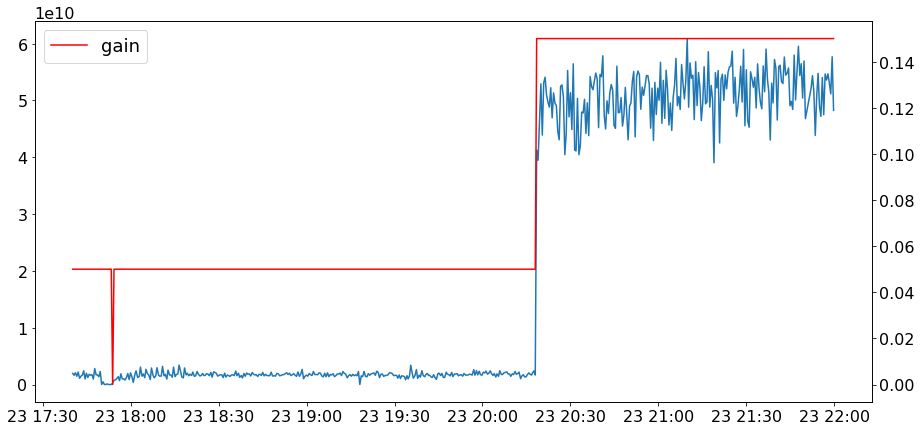

In [10]:
fig, ax = plt.subplots(figsize = (15,7))
ax.plot(merge_df.timestamp, merge_df.intensity)
ax2 = ax.twinx()
ax2.plot(merge_df.timestamp, merge_df.gain, c="r", label="gain")
ax2.legend()

The mean intensity is 1691800544.0217392
The standard deviation is 710186369.5514427
The coefficient of variation is 41.97813814760879
The mean intensity is 1726873103.5714285
The standard deviation is 334508851.40286577
The coefficient of variation is 19.37078356892884


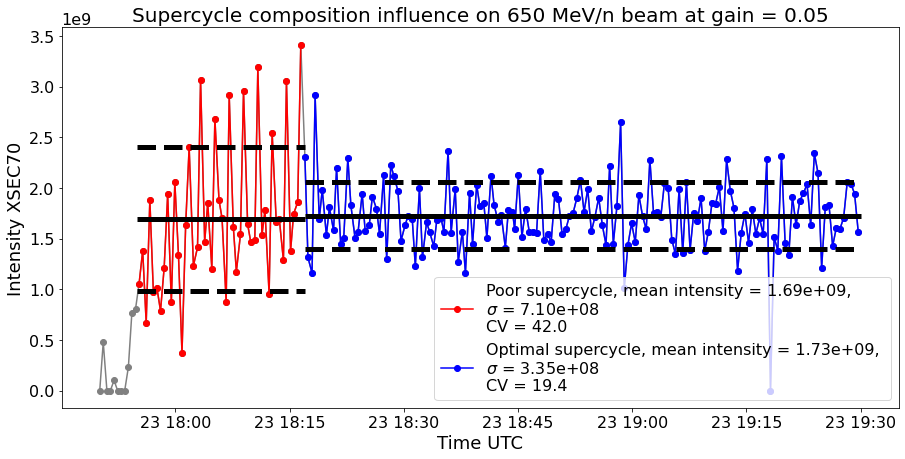

In [11]:
fig, ax = plt.subplots(figsize = (15,7))

start_time = pd.Timestamp('2022-11-23 17:50:00')
end_time = pd.Timestamp('2022-11-23 19:30:00')
merge_df_subset = merge_df[(merge_df.gain <=0.05) & (merge_df['timestamp'] >= start_time) & (merge_df['timestamp'] <= end_time)]
ax.plot(merge_df_subset.timestamp, merge_df_subset.intensity, marker="o", c="gray")

# ax2 = ax.twinx()
# ax2.plot(merge_df_subset.timestamp, merge_df_subset.gain, c="r", label="gain")
# ax2.legend()


# Range with AD cycle in front
start_time = pd.Timestamp('2022-11-23 17:55:00')
end_time = pd.Timestamp('2022-11-23 18:17:00')
merge_df_subset = merge_df[(merge_df.gain <=0.05) & (merge_df['timestamp'] >= start_time) & (merge_df['timestamp'] <= end_time)]

# Mean
intensity_mean = np.mean(merge_df_subset.intensity)
print(f"The mean intensity is {intensity_mean}")
ax.hlines(intensity_mean, start_time, end_time, zorder = 99, lw=5, color="k")

# Standard deviation
intensity_std  = np.std(merge_df_subset.intensity)
print(f"The standard deviation is {intensity_std }")
ax.hlines(intensity_mean+intensity_std, start_time, end_time, zorder = 99, lw=5, color="k", ls="--")
ax.hlines(intensity_mean-intensity_std, start_time, end_time, zorder = 99, lw=5, color="k", ls="--")

# Coefficient of variation
cv = (intensity_std / intensity_mean) * 100
print(f"The coefficient of variation is {cv}")

ax.plot(merge_df_subset.timestamp, merge_df_subset.intensity, marker="o", color="red", label=f"Poor supercycle, mean intensity = {'{:.2e}'.format(intensity_mean)}, \n$\sigma$ = {'{:.2e}'.format(intensity_std)} \nCV = {round(cv,1)}")


# Range with only EAST cycle in front
start_time = pd.Timestamp('2022-11-23 18:17:00')
end_time = pd.Timestamp('2022-11-23 19:30:00')
merge_df_subset = merge_df[(merge_df.gain <=0.05) & (merge_df['timestamp'] >= start_time) & (merge_df['timestamp'] <= end_time)]


# Mean
intensity_mean = np.mean(merge_df_subset.intensity)
print(f"The mean intensity is {intensity_mean}")
ax.hlines(intensity_mean, start_time, end_time, zorder = 99, lw=5, color="k")

# Standard deviation
intensity_std  = np.std(merge_df_subset.intensity)
print(f"The standard deviation is {intensity_std }")
ax.hlines(intensity_mean+intensity_std, start_time, end_time, zorder = 99, lw=5, color="k", ls="--")
ax.hlines(intensity_mean-intensity_std, start_time, end_time, zorder = 99, lw=5, color="k", ls="--")

# Coefficient of variation
cv = (intensity_std / intensity_mean) * 100
print(f"The coefficient of variation is {cv}")


ax.plot(merge_df_subset.timestamp, merge_df_subset.intensity, marker="o", color="blue", label=f"Optimal supercycle, mean intensity = {'{:.2e}'.format(intensity_mean)}, \n$\sigma$ = {'{:.2e}'.format(intensity_std)} \nCV = {round(cv,1)}")


ax.legend(fontsize = 16)

ax.set_xlabel("Time UTC")
ax.set_ylabel("Intensity XSEC70")
ax.set_title("Supercycle composition influence on 650 MeV/n beam at gain = 0.05", fontsize=20)

plt.savefig("supercycle_composition.png", facecolor='white', transparent=False, dpi = 150, bbox_inches='tight')

# Look at the whole flux variation

In [12]:
with open('../quad-scan-east/rfko_gain_dataframe.pickle', 'rb') as f:
    gain_df = pickle.load(f)
gain_df['timestamp'] -= timedelta(hours=1)

In [13]:
# Time in UTC
start = gain_df['timestamp'].min()
stop = gain_df['timestamp'].max()
selector = ['CPS.USER.MD5', 'CPS.USER.EAST3', 'CPS.USER.EAST4']

spills = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(stop).entity().parameter("T08.XSEC070-I/IntensityMeasurement").build()

spills = spills.filter(spills.selector.isin(selector)).toPandas()

In [14]:
# Convert the 'acqStamp' column to datetime and create a new column
spills['timestamp'] = pd.to_datetime(spills['acqStamp'], unit='ns')
spills_sorted = spills.sort_values(by='timestamp')

In [15]:
# Merge with the gain dataframe
merge_df = pd.merge_asof(spills_sorted, gain_df, on='timestamp', direction='nearest')

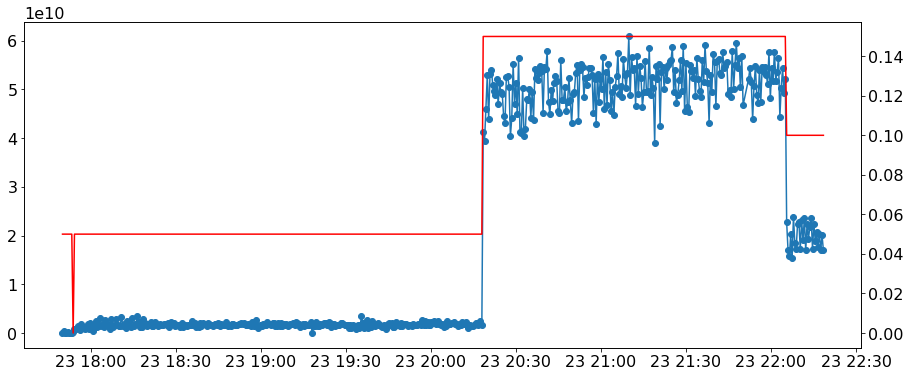

In [16]:
start_time = pd.Timestamp('2022-11-23 17:50:00')
end_time = pd.Timestamp('2022-11-23 22:30:00')
df = merge_df[(merge_df.timestamp >= start_time) & (merge_df.timestamp <= end_time) & (merge_df.selector=="CPS.USER.MD5")]

fig, ax = plt.subplots(figsize=(15,6))
ax.plot(df.timestamp, df.intensity, marker="o")

ax2 = ax.twinx()
ax2.plot(df.timestamp, df.gain, c="r")

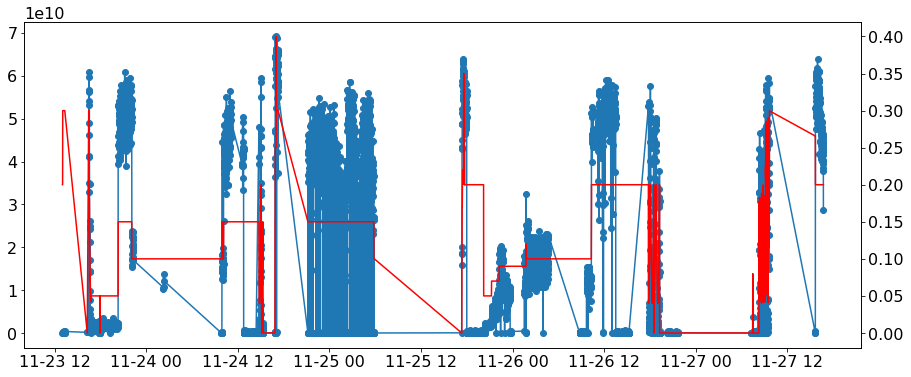

In [17]:
df = merge_df[(merge_df.selector=="CPS.USER.MD5")]

fig, ax = plt.subplots(figsize=(15,6))
ax.plot(df.timestamp, df.intensity, marker="o")

ax2 = ax.twinx()
ax2.plot(df.timestamp, df.gain, c="r")

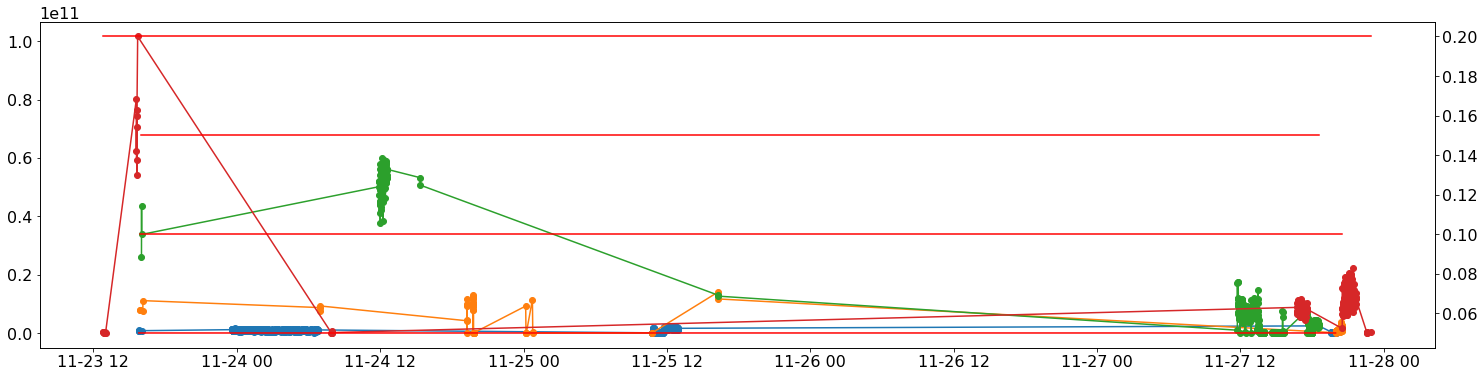

In [18]:
user = "CPS.USER.EAST4"

fig, ax = plt.subplots(figsize=(25,6))
ax2 = ax.twinx()

df = merge_df[(merge_df.selector==user) & (merge_df.gain == 0.05) & (merge_df.intensity>0)]
ax.plot(df.timestamp, df.intensity, marker="o")
ax2.plot(df.timestamp, df.gain, c="r")

df = merge_df[(merge_df.selector==user) & (merge_df.gain == 0.1) & (merge_df.intensity>0)]
ax.plot(df.timestamp, df.intensity, marker="o")
ax2.plot(df.timestamp, df.gain, c="r")

df = merge_df[(merge_df.selector==user) & (merge_df.gain == 0.15) & (merge_df.intensity>0)]
ax.plot(df.timestamp, df.intensity, marker="o")
ax2.plot(df.timestamp, df.gain, c="r")

df = merge_df[(merge_df.selector==user) & (merge_df.gain == 0.2) & (merge_df.intensity>0)]
ax.plot(df.timestamp, df.intensity, marker="o")
ax2.plot(df.timestamp, df.gain, c="r")

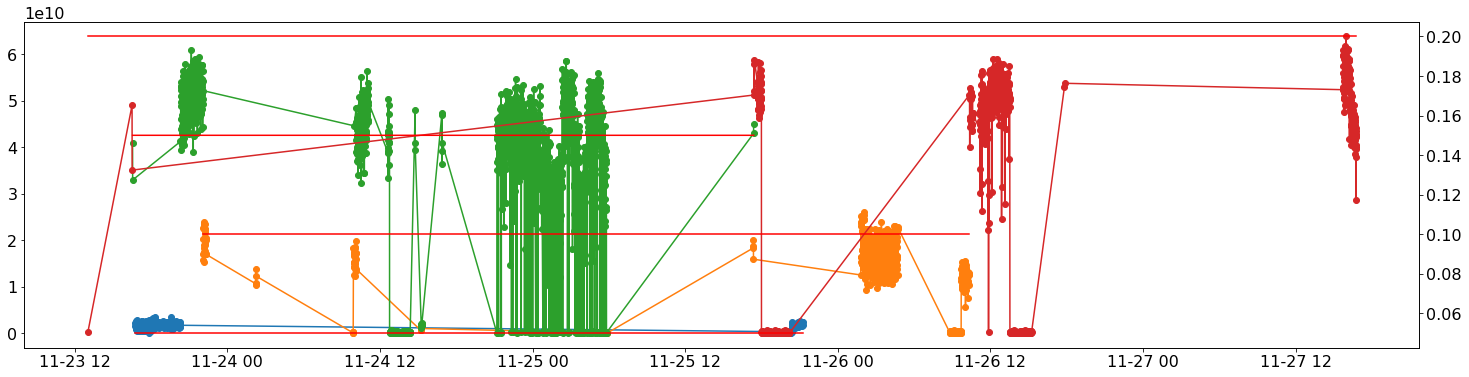

In [19]:
fig, ax = plt.subplots(figsize=(25,6))
ax2 = ax.twinx()

df = merge_df[(merge_df.selector=="CPS.USER.MD5") & (merge_df.gain == 0.05) & (merge_df.intensity>0)]
ax.plot(df.timestamp, df.intensity, marker="o")
ax2.plot(df.timestamp, df.gain, c="r")

df = merge_df[(merge_df.selector=="CPS.USER.MD5") & (merge_df.gain == 0.1) & (merge_df.intensity>0)]
ax.plot(df.timestamp, df.intensity, marker="o")
ax2.plot(df.timestamp, df.gain, c="r")

df = merge_df[(merge_df.selector=="CPS.USER.MD5") & (merge_df.gain == 0.15) & (merge_df.intensity>0)]
ax.plot(df.timestamp, df.intensity, marker="o")
ax2.plot(df.timestamp, df.gain, c="r")

df = merge_df[(merge_df.selector=="CPS.USER.MD5") & (merge_df.gain == 0.2) & (merge_df.intensity>0)]
ax.plot(df.timestamp, df.intensity, marker="o")
ax2.plot(df.timestamp, df.gain, c="r")

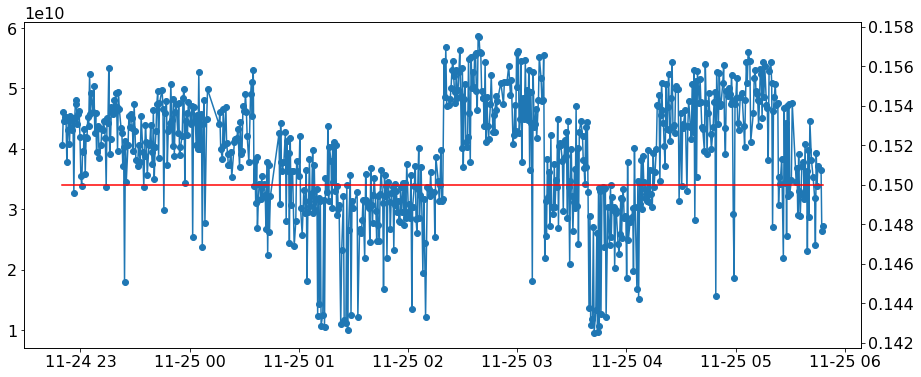

In [20]:
start_time = pd.Timestamp('2022-11-24 22:50:00')
end_time = pd.Timestamp('2022-11-25 12:00:00')
df = merge_df[(merge_df.timestamp >= start_time) & (merge_df.timestamp <= end_time) & (merge_df.selector=="CPS.USER.MD5") & (merge_df.intensity>0.1e10)]

fig, ax = plt.subplots(figsize=(15,6))
ax.plot(df.timestamp, df.intensity, marker="o")

ax2 = ax.twinx()
ax2.plot(df.timestamp, df.gain, c="r")

The mean intensity is 1278574052.0270271
The standard deviation is 462529881.68907523
The coefficient of variation is 36.17544724576485
The mean intensity is 6763701440.65534
The standard deviation is 7727695284.443998
The coefficient of variation is 114.25246002128763
The mean intensity is 49999451340.38461
The standard deviation is 12672101183.573265
The coefficient of variation is 25.344480477004744
The mean intensity is 62383037691.36636
The standard deviation is 29382645084.4428
The coefficient of variation is 47.10037563385483


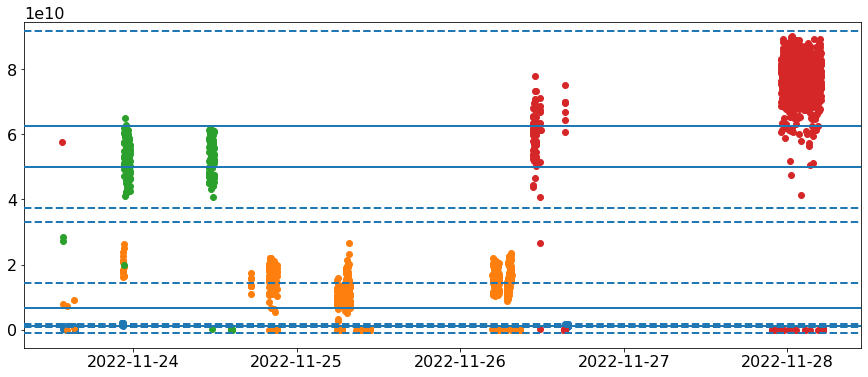

In [21]:
intensity_mean_list = []

fig, ax = plt.subplots(figsize=(15,6))
for gain in [0.05, 0.1, 0.15, 0.2]:

    df = merge_df[(merge_df.selector=="CPS.USER.EAST3") & (merge_df.gain == gain)]
    ax.scatter(df.timestamp, df.intensity, marker="o")

    # Mean
    intensity_mean = np.mean(df.intensity)
    print(f"The mean intensity is {intensity_mean}")
    ax.axhline(intensity_mean, zorder = 99, lw=2)

    # Standard deviation
    intensity_std  = np.std(df.intensity)
    print(f"The standard deviation is {intensity_std }")
    ax.axhline(intensity_mean+intensity_std, zorder = 99, lw=2, ls="--")
    ax.axhline(intensity_mean-intensity_std, zorder = 99, lw=2, ls="--")


    # Coefficient of variation
    cv = (intensity_std / intensity_mean) * 100
    print(f"The coefficient of variation is {cv}")
    
    intensity_mean_list.append(intensity_mean)

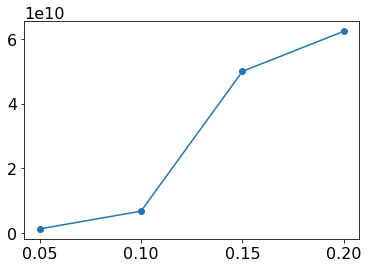

In [22]:
fig, ax = plt.subplots()
ax.plot([0.05, 0.1, 0.15, 0.2], intensity_mean_list, marker="o")

The mean intensity is 914540896.5662651
The standard deviation is 442669691.3135668
The coefficient of variation is 48.40348780197958
The mean intensity is 2125288784.2592592
The standard deviation is 3451229420.3435307
The coefficient of variation is 162.38872787099424
The mean intensity is 9421840165.217392
The standard deviation is 15826195834.943268
The coefficient of variation is 167.97351215284712
The mean intensity is 10136103829.107143
The standard deviation is 9692976163.692297
The coefficient of variation is 95.62822487924456


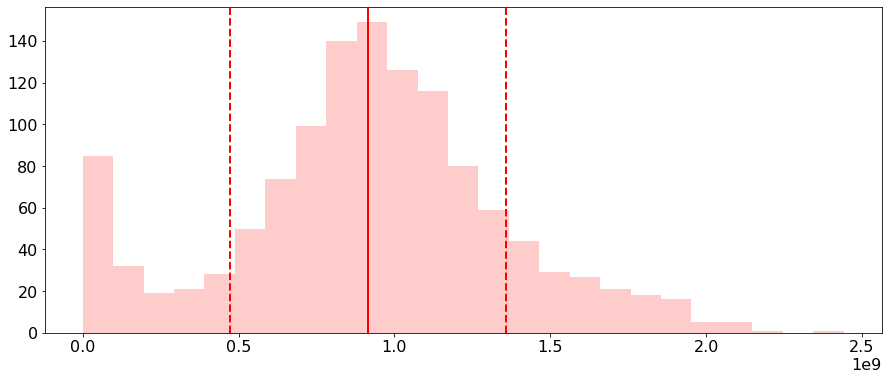

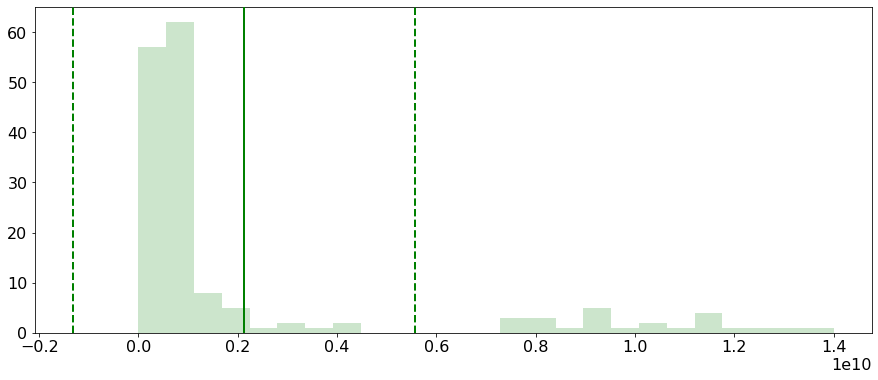

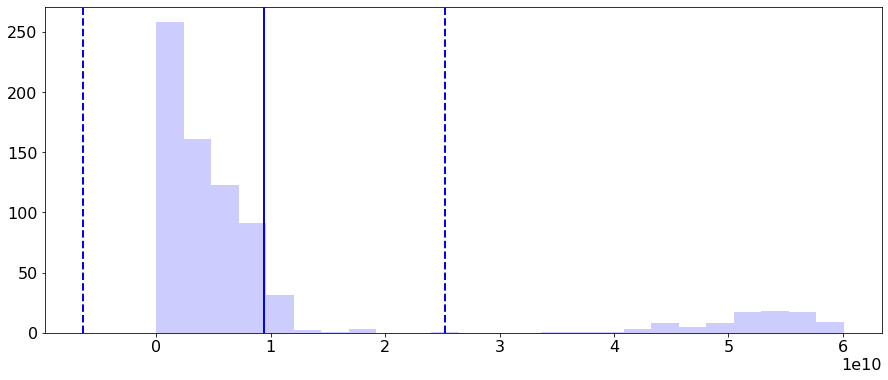

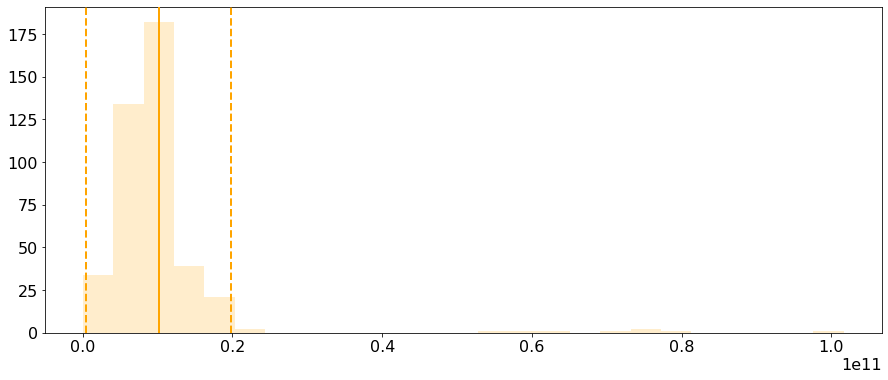

In [23]:
intensity_mean_list = []

colors = ['red', 'green', 'blue', 'orange']  # List of four colors



for i, gain in enumerate([0.05, 0.1, 0.15, 0.2]):
    fig, ax = plt.subplots(figsize=(15, 6))
    df = merge_df[(merge_df.selector == "CPS.USER.EAST4") & (merge_df.gain == gain)]
#     if gain == 0.05:
#         df = df[(df.intensity > 0.3e9)]
#     else:
#         df = df[df.intensity > 0.5e10]
    
    # Histogram
    ax.hist(df.intensity, bins=25, alpha=0.2, color=colors[i % len(colors)])  # Cycle through colors
    
    # Mean
    intensity_mean = np.mean(df.intensity)
    print(f"The mean intensity is {intensity_mean}")
    ax.axvline(intensity_mean, zorder=99, lw=2, color=colors[i % len(colors)])  # Cycle through colors
    
    # Standard deviation
    intensity_std = np.std(df.intensity)
    print(f"The standard deviation is {intensity_std}")
    ax.axvline(intensity_mean + intensity_std, zorder=99, lw=2, ls="--", color=colors[i % len(colors)])  # Cycle through colors
    ax.axvline(intensity_mean - intensity_std, zorder=99, lw=2, ls="--", color=colors[i % len(colors)])  # Cycle through colors
    
    # Coefficient of variation
    cv = (intensity_std / intensity_mean) * 100
    print(f"The coefficient of variation is {cv}")

plt.show()


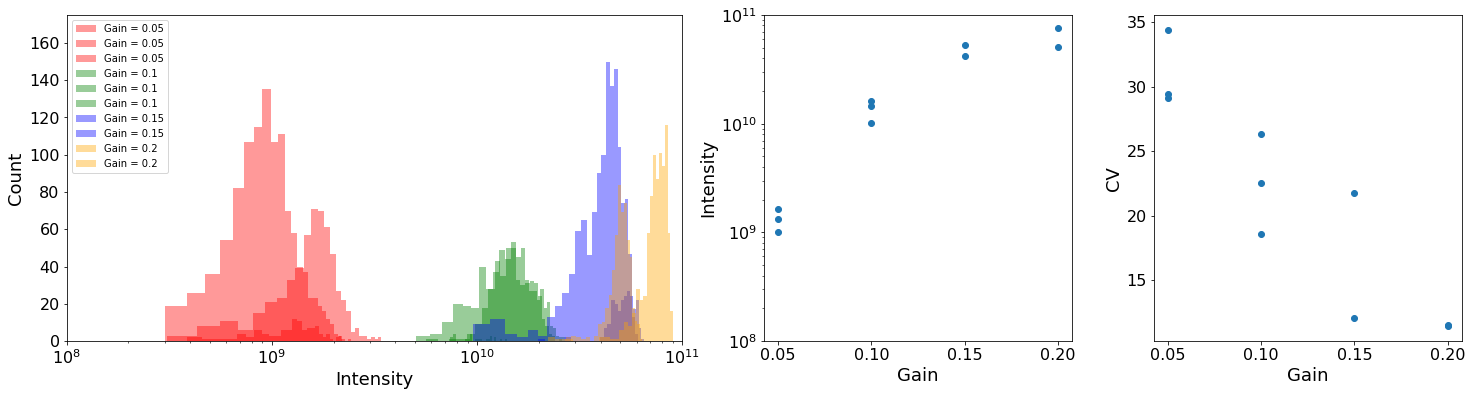

In [24]:
fig = plt.figure(figsize=(25, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

d = {'gain': [], 'user': [], 'intensity_mean': [], 'intensity_std': [], 'intensity_cv': []}
df_intensity = pd.DataFrame(data=d)

for i, gain in enumerate([0.05, 0.1, 0.15, 0.2]):
    colors = ['red', 'green', 'blue', 'orange']  # List of four colors



    for user in ["CPS.USER.MD5", "CPS.USER.EAST3", "CPS.USER.EAST4"]:
        
        df = merge_df[(merge_df.selector == user) & (merge_df.gain == gain)]
        if gain == 0.05:
            df = df[(df.intensity > 0.3e9)]
        else:
            df = df[df.intensity > 0.5e10]
        if (user == "CPS.USER.EAST4") & (gain > 0.1):
            break
            
        # Histogram
        ax1.hist(df.intensity, bins=25, alpha=0.4, color=colors[i % len(colors)], label=f"Gain = {gain}")  # Cycle through colors

        # Mean
        intensity_mean = np.mean(df.intensity)
#         ax1.axvline(intensity_mean, zorder=99, lw=2, color=colors[i % len(colors)])  # Cycle through colors

        # Standard deviation
        intensity_std = np.std(df.intensity)
#         ax1.axvline(intensity_mean + intensity_std, zorder=99, lw=2, ls="--", color=colors[i % len(colors)])  # Cycle through colors
#         ax1.axvline(intensity_mean - intensity_std, zorder=99, lw=2, ls="--", color=colors[i % len(colors)])  # Cycle through colors

        # Coefficient of variation
        cv = (intensity_std / intensity_mean) * 100

        d = {'gain': [gain], 'user': [user], 'intensity_mean': [intensity_mean], 'intensity_std': [intensity_std], 'intensity_cv': [cv]}
        df_intensity2 = pd.DataFrame(data=d)
        df_intensity = pd.concat([df_intensity, df_intensity2])


ax1.set_xlabel("Intensity")
ax1.set_ylabel("Count")
ax1.set_xlim(1e8,1e11)
ax1.set_xscale("log")
ax1.set_ylim(0,175)

ax2.scatter(df_intensity.gain, df_intensity.intensity_mean, marker="o")
ax2.set_yscale("log")

ax2.set_xlabel("Gain")
ax2.set_ylabel("Intensity")

ax2.set_ylim(1e8,1e11)

ax3.scatter(df_intensity.gain, df_intensity.intensity_cv, marker="o")

ax3.set_xlabel("Gain")
ax3.set_ylabel("CV")

ax1.legend(fontsize=10)

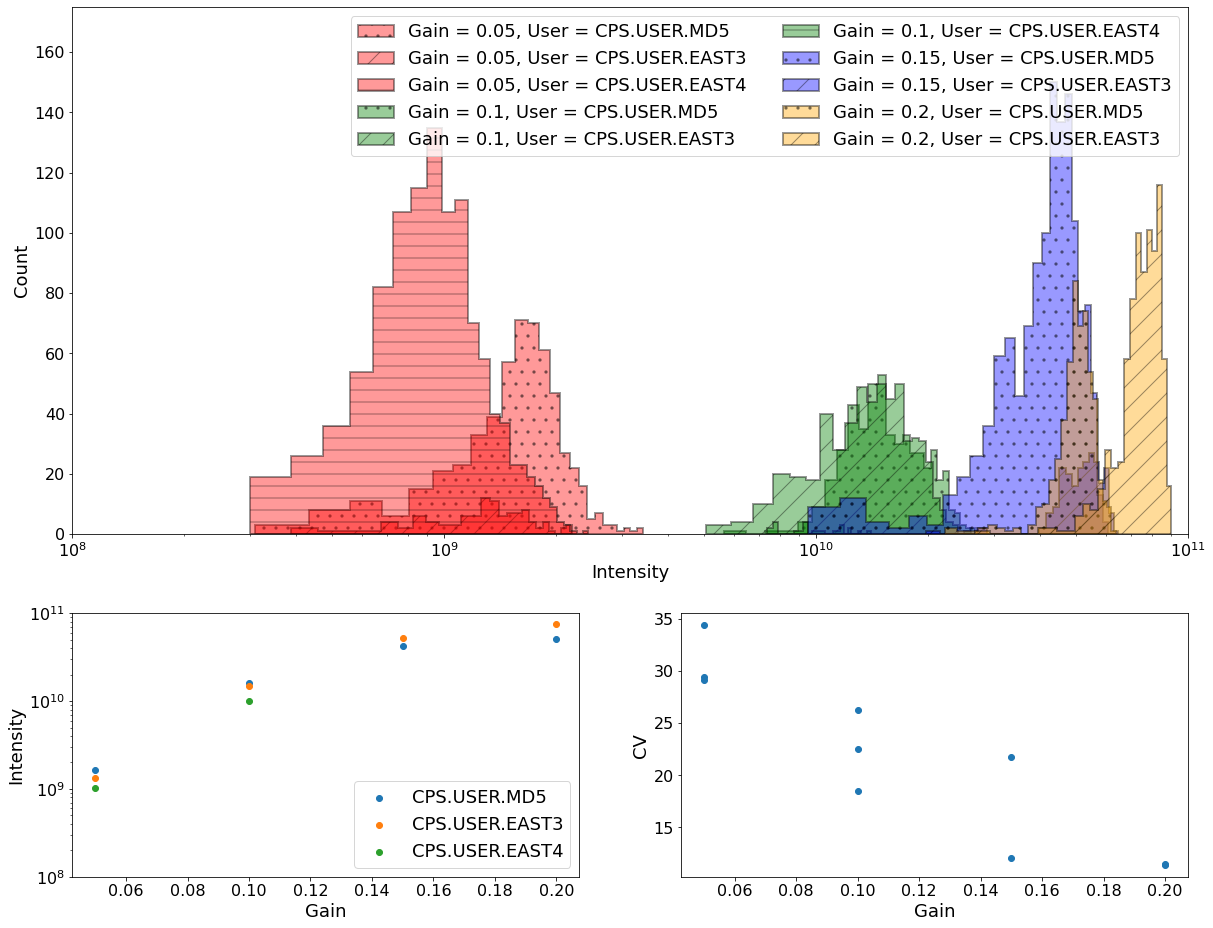

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

fig = plt.figure(figsize=(20, 16))

gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1]) 
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])

df_intensity = pd.DataFrame(columns=['gain', 'user', 'intensity_mean', 'intensity_std', 'intensity_cv'])

patterns_dict = {"CPS.USER.MD5": ".", "CPS.USER.EAST3": "/", "CPS.USER.EAST4": "-"}

colors = ['red', 'green', 'blue', 'orange']  # List of four colors

for i, gain in enumerate([0.05, 0.1, 0.15, 0.2]):

    for user in ["CPS.USER.MD5", "CPS.USER.EAST3", "CPS.USER.EAST4"]:
        if (user == "CPS.USER.EAST4") and (gain > 0.1):
            break

        df = merge_df[(merge_df.selector == user) & (merge_df.gain == gain)]
        if gain == 0.05:
            df = df[df.intensity > 0.3e9]
        else:
            df = df[df.intensity > 0.5e10]

        # Histogram
        ax1.hist(df.intensity, bins=25, alpha=0.4, color=colors[i % len(colors)], hatch=patterns_dict.get(user),
                 histtype='stepfilled', linewidth=2, edgecolor='black', label=f"Gain = {gain}, User = {user}")

        # Statistics
        intensity_mean = np.mean(df.intensity)
        intensity_std = np.std(df.intensity)
        cv = (intensity_std / intensity_mean) * 100

        # Collect data for DataFrame
        df_intensity = df_intensity.append({'gain': gain, 'user': user, 'intensity_mean': intensity_mean,
                                            'intensity_std': intensity_std, 'intensity_cv': cv}, ignore_index=True)

ax1.set_xlabel("Intensity")
ax1.set_ylabel("Count")
ax1.set_xlim(1e8, 1e11)
ax1.set_xscale("log")
ax1.set_ylim(0, 175)

for user in ["CPS.USER.MD5", "CPS.USER.EAST3", "CPS.USER.EAST4"]:
    ax2.scatter(df_intensity[df_intensity.user == user].gain, df_intensity[df_intensity.user == user].intensity_mean, marker="o", label=f"{user}")
ax2.set_yscale("log")
ax2.set_xlabel("Gain")
ax2.set_ylabel("Intensity")
ax2.set_ylim(1e8, 1e11)
ax2.legend()

ax3.scatter(df_intensity.gain, df_intensity.intensity_cv, marker="o")
ax3.set_xlabel("Gain")
ax3.set_ylabel("CV")

ax1.legend(ncol=2)

plt.savefig("intensity_variation.png", facecolor='white', transparent=False, dpi = 150, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(20, 8))
df = merge_df[merge_df['gain'].isin([0.05, 0.1, 0.15, 0.2])].dropna()
sns.violinplot(data=df, x="gain", y="intensity", hue="selector")
plt.yscale('log')